In [49]:
import cma
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.integrate import ode
from scipy.signal import butter, sosfiltfilt, hilbert
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d


In [28]:
# ==========================================
# CIRCUIT PARAMETERS
# ==========================================
N = 20                          # Number of resonator fock states

# Circuit parameters
wr = 7.062e9 * 2 * np.pi          # Resonator frequency (7.062 GHz)[from reference]
wq = 5.092e9 * 2 * np.pi          # Qubit frequency (5.092 GHz)[from reference]
w_if = 0.05e9 * 2 * np.pi         # Intermediate frequency used for AWG (50 MHz) [self-defined, not from reference]
w_lo = wr - w_if                  # Local Oscillator frequency (close to resonator freq)
delta = abs(wr - wq)              # Detuning between qubit and resonator (1.97 GHz)[from reference]
k = 0.00535e9 * 2 * np.pi         # Resonator decay rate (5.35 MHz)[from reference]
g = 0.1029e9 * 2 * np.pi          # Coupling strength (102.9 MHz)[from reference]
gamma_1 = 0.001e9 * 2 * np.pi     # Qubit decay (0.1 MHz) [self-defined, not from reference]
gamma_2 = 0.001e9 * 2 * np.pi     # Qubit dephase (0.1 MHz) [self-defined, not from reference]
phi = 0.0 * np.pi                   # AWG phase (set to zero by default)
alpha = 0.157e9 * 2 * np.pi       # Anharmonity (157 MHz) [Chosen to align results]
K = alpha * (g/delta)**4          # Kerr self-nonlinearity (8.18 KHz) [Derived from Yvonne reference]
chi = 2 * alpha * (g/delta)**2    # Dispersive shift, cross non-linearity (5.382 MHz) [Derived from Yvonne reference]

duration = 800e-9
dt = 1e-9
tlist = np.arange(0, duration, dt)  # Time from 0 to 800 ns

### AWG Generation of I/Q components for input into IQ mixer

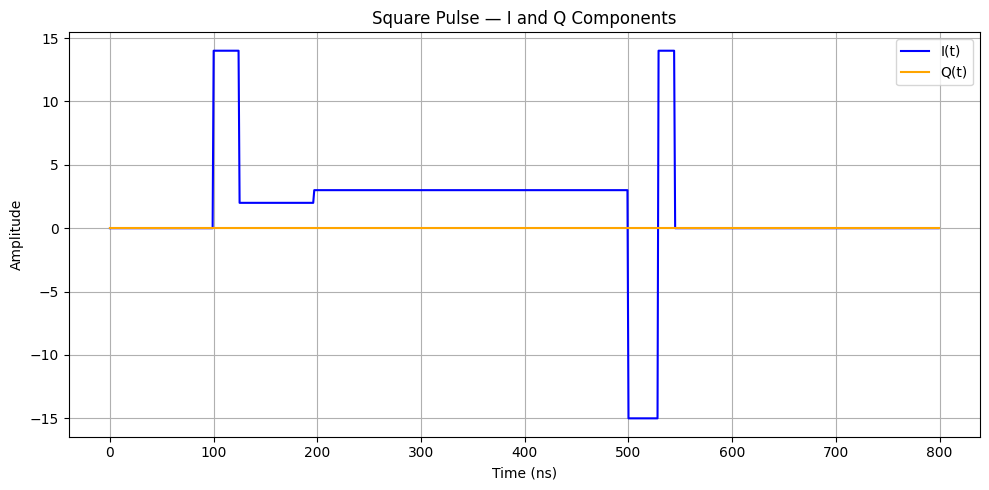

In [40]:
ringup1_amp = 14
ringdown1_amp = 2
ringup2_amp = 14
drive_amp = 3
ringdown2_amp = -15

optimal_ringup1_time = 24e-9
optimal_ringdown1_time = 72e-9
optimal_ringup2_time = 16e-9
optimal_ringdown2_time = 29e-9

pulse_start = 100e-9
pulse_width = 400e-9

def smooth_ramp(t, T):
    return np.sin(np.pi * t / (2*T))  # cosine ramp

def smooth_ramp_reverse(t, T):
    return np.cos(np.pi * t / (2*T))

# ==========================================
# BASEBAND CLEAR PULSE
# ==========================================
def b_in(t):
    try:
        if  t<= pulse_start:
            return 0.0
        elif t<= pulse_start + optimal_ringup1_time:
            return ringup1_amp 
        elif t <= pulse_start + optimal_ringup1_time + optimal_ringdown1_time:
            return ringdown1_amp
        elif t <= pulse_start + pulse_width:
            return drive_amp
        elif t <= pulse_start + pulse_width + optimal_ringdown2_time:
            return ringdown2_amp 
        elif t <= pulse_start + pulse_width + optimal_ringdown2_time + optimal_ringup2_time:
            return ringup2_amp
        else:   
            return 0.0
    
    except Exception as e:
        print(f"b_in error at t={t}: {e}")
        return 0.0
    
# def b_in(t):
#     try:
#         if  t<= pulse_start:
#             return 0.0
#         elif t<= pulse_start + optimal_ringup1_time:
#             return ringup1_amp * smooth_ramp(t - pulse_start, optimal_ringup1_time) 
#         elif t <= pulse_start + optimal_ringup1_time + optimal_ringdown1_time:
#             return ringdown1_amp * smooth_ramp_reverse(t - (pulse_start + optimal_ringup1_time), optimal_ringdown1_time)
#         elif t <= pulse_start + pulse_width:
#             return drive_amp
#         elif t <= pulse_start + pulse_width + optimal_ringdown2_time:
#             return ringdown2_amp * smooth_ramp_reverse(t - (pulse_start + pulse_width), optimal_ringdown2_time)
#         elif t <= pulse_start + pulse_width + optimal_ringdown2_time + optimal_ringup2_time:
#             return ringup2_amp * smooth_ramp(t - (pulse_start + pulse_width + optimal_ringdown2_time), optimal_ringup2_time) 
#         else:   
#             return 0.0
    
#     except Exception as e:
#         print(f"b_in error at t={t}: {e}")
#         return 0.0
    
envelope = np.array([b_in(t) for t in tlist.flatten()])

# I and Q components
I_t = np.real(envelope)
Q_t = np.imag(envelope)


plt.figure(figsize=(10, 5))

plt.plot(tlist/1e-9, I_t, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t, label='Q(t)', color='orange')
plt.title("Square Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


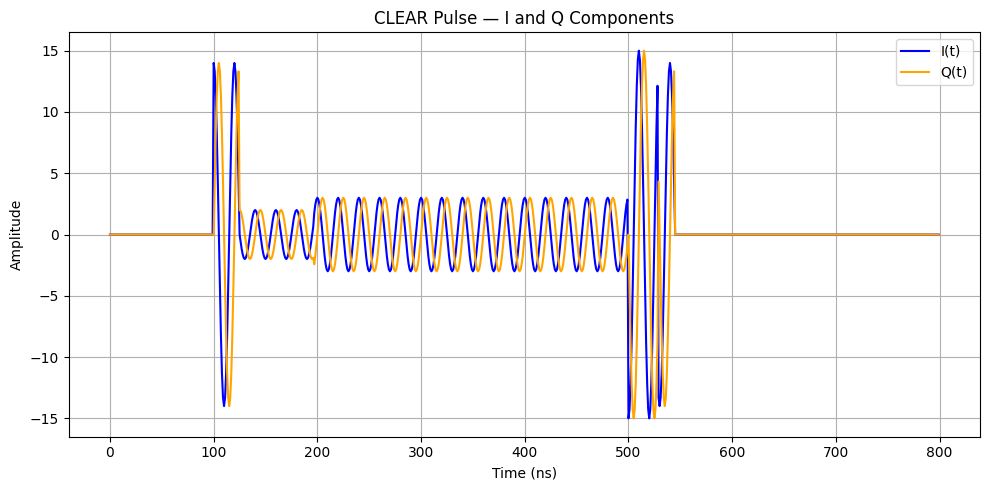

In [41]:
envelope = envelope * np.exp(1j * (w_if * tlist + phi))

# I and Q components
I_t = np.real(envelope)
Q_t = np.imag(envelope)


plt.figure(figsize=(10, 5))

plt.plot(tlist/1e-9, I_t, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t, label='Q(t)', color='orange')
plt.title("CLEAR Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### I/Q Mixing of Envelope with LO for RF output

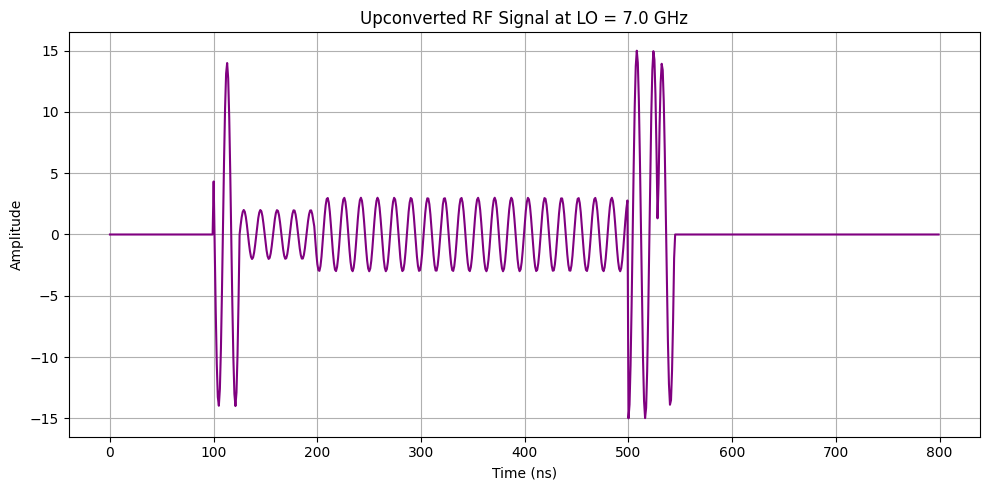

In [46]:
# RF signal must be real-valued (actual voltage)
lo_cos = np.cos(w_lo * tlist)
lo_sin = np.sin(w_lo * tlist)
RF_t = I_t * lo_cos - Q_t * lo_sin

plt.figure(figsize=(10, 5))
plt.plot(tlist/1e-9, RF_t, color='purple')
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.title(f"Upconverted RF Signal at LO = {w_lo/(2*np.pi * 1e9):.1f} GHz")
plt.grid()

plt.tight_layout()
plt.show()

### Sanity check: Demodulation to retrieve original signal

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


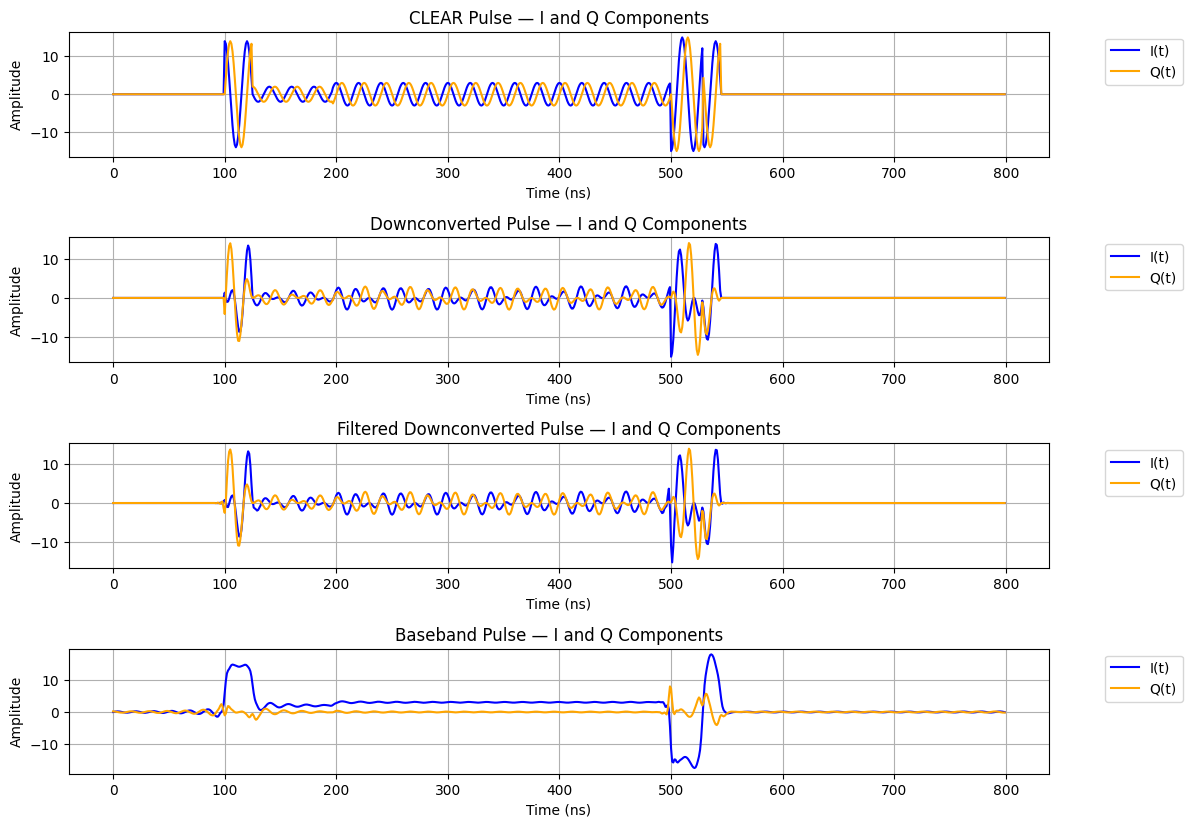

In [ ]:
RF_t = hilbert(RF_t)  # Ensure RF signal is analytic
I_t_down = RF_t * lo_cos
Q_t_down = - RF_t * lo_sin

cutoff_frequency_lo = 2 * w_lo/(2*np.pi) # Hz
sampling_rate_lo = 5e10 # Hz
order = 4

# Calculate normalized cutoff frequency
nyquist_frequency_lo = 0.5 * sampling_rate_lo
normalized_cutoff_lo = cutoff_frequency_lo / nyquist_frequency_lo

# Design the Butterworth filter
sos_lo = butter(order, normalized_cutoff_lo, btype='low', analog=False, output='sos')
I_t_filt = sosfiltfilt(sos_lo, I_t_down)
Q_t_filt = sosfiltfilt(sos_lo, Q_t_down)

V_t_filt = I_t_filt + 1j * Q_t_filt # Enters complex plane

V_t_base = V_t_filt * np.exp(-1j * (w_if * tlist + phi)) # Get back complex (actually just real) envelope
I_t_base = np.real(V_t_base)
Q_t_base = np.imag(V_t_base)

plt.figure(figsize=(12, 10))

plt.subplot(5,1,1)
plt.plot(tlist/1e-9, I_t, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t, label='Q(t)', color='orange')
plt.title("CLEAR Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

# Demodulate with LO, Contains second term that is a double-LO-frequency image
plt.subplot(5,1,2)
plt.plot(tlist/1e-9, I_t_down, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t_down, label='Q(t)', color='orange')
plt.title("Downconverted Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

# Filtered out double-LO-frequency image, recovered original image
plt.subplot(5,1,3)
plt.plot(tlist/1e-9, I_t_filt, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t_filt, label='Q(t)', color='orange')
plt.title("Filtered Downconverted Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

# Demodulate with LO, removes complex componen to get real pulse
plt.subplot(5,1,4)
plt.plot(tlist/1e-9, I_t_base, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t_base, label='Q(t)', color='orange')
plt.title("Baseband Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

### Interaction with the readout resonator (Rotating Frame)

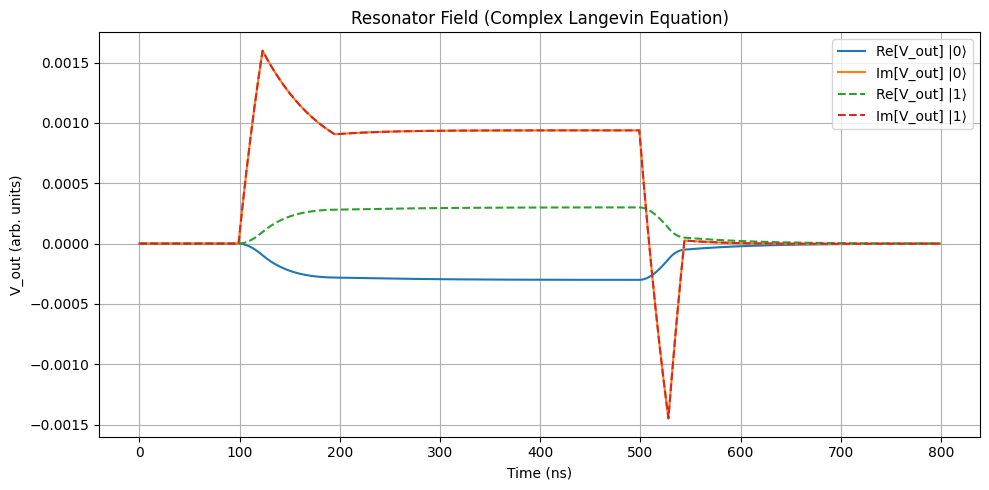

In [18]:
# Define drive
def b_in(t):
    try:
        if  t<= pulse_start:
            return 0.0
        elif t<= pulse_start + optimal_ringup1_time:
            return ringup1_amp 
        elif t <= pulse_start + optimal_ringup1_time + optimal_ringdown1_time:
            return ringdown1_amp
        elif t <= pulse_start + pulse_width:
            return drive_amp
        elif t <= pulse_start + pulse_width + optimal_ringdown2_time:
            return ringdown2_amp 
        elif t <= pulse_start + pulse_width + optimal_ringdown2_time + optimal_ringup2_time:
            return ringup2_amp
        else:   
            return 0.0
    
    except Exception as e:
        print(f"b_in error at t={t}: {e}")
        return 0.0
    
# Define Heisenburg picture 
def langevin(t, a_vec, qubit_state):
    omega_eff = chi * qubit_state
    return -1j * omega_eff * a_vec - (k / 2) * a_vec +  1j * np.sqrt(k) * b_in(t)

def run_langevin(qubit_state):
    solver = ode(langevin)
    solver.set_integrator('zvode', method='bdf')  # complex-valued ODE solver
    solver.set_initial_value(0.0+0.0j, tlist[0])
    solver.set_f_params(qubit_state)

    a_vals = []

    for _ in range(len(tlist)):
        if not solver.successful():
            print("Integration failed at t =", solver.t)
            break
        solver.integrate(solver.t + dt)
        a_vals.append(solver.y)

    return np.array(a_vals)

# Run for both qubit states
a_0 = run_langevin(-1)
a_1 = run_langevin(1)

plt.figure(figsize=(10, 5))
plt.plot(tlist * 1e9, np.real(a_0), label='Re[V_out] |0⟩')
plt.plot(tlist * 1e9, np.imag(a_0), label='Im[V_out] |0⟩')
plt.plot(tlist * 1e9, np.real(a_1), '--', label='Re[V_out] |1⟩')
plt.plot(tlist * 1e9, np.imag(a_1), '--', label='Im[V_out] |1⟩')
plt.xlabel("Time (ns)")
plt.ylabel("V_out (arb. units)")
plt.title("Resonator Field (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

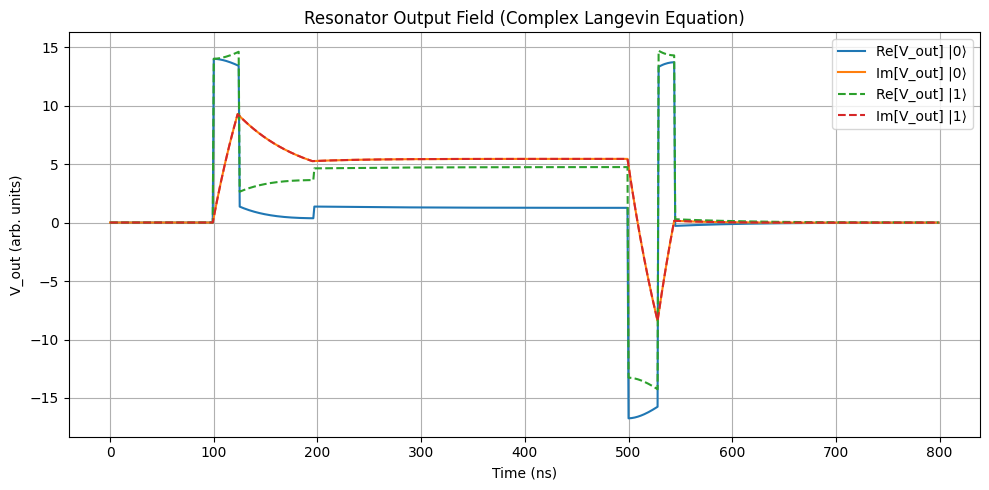

In [19]:
V_out_0 = np.sqrt(k) * a_0.flatten() + np.array([b_in(t) for t in tlist])
V_out_1 = np.sqrt(k) * a_1.flatten() + np.array([b_in(t) for t in tlist])

plt.figure(figsize=(10, 5))
plt.plot(tlist * 1e9, np.real(V_out_0).flatten(), label='Re[V_out] |0⟩')
plt.plot(tlist * 1e9, np.imag(V_out_0).flatten(), label='Im[V_out] |0⟩')
plt.plot(tlist * 1e9, np.real(V_out_1).flatten(), '--', label='Re[V_out] |1⟩')
plt.plot(tlist * 1e9, np.imag(V_out_1.flatten()), '--', label='Im[V_out] |1⟩')
plt.xlabel("Time (ns)")
plt.ylabel("V_out (arb. units)")
plt.title("Resonator Output Field (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

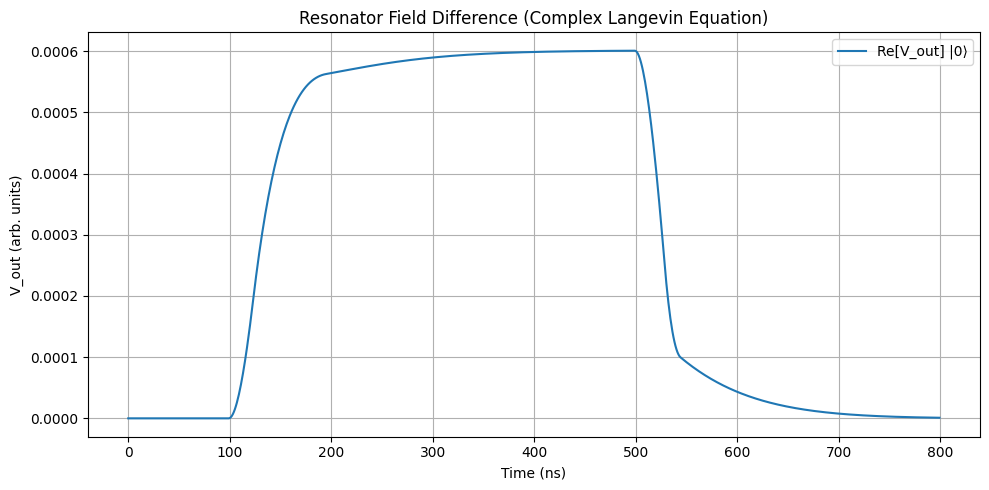

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(tlist * 1e9, abs(np.real(a_0)-np.real(a_1)), label='Re[V_out] |0⟩')
plt.xlabel("Time (ns)")
plt.ylabel("V_out (arb. units)")
plt.title("Resonator Field Difference (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

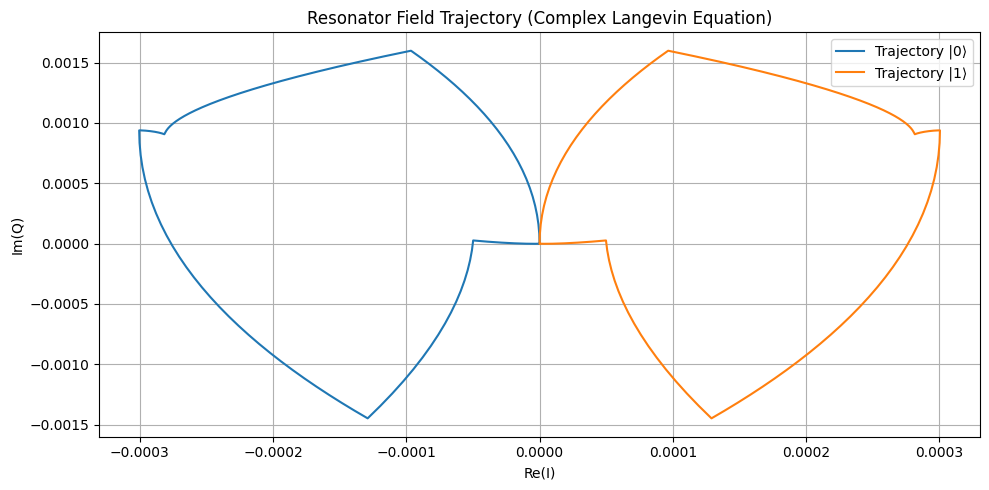

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(np.real(a_0), np.imag(a_0), label='Trajectory |0⟩')
plt.plot(np.real(a_1), np.imag(a_1), label='Trajectory |1⟩')
plt.xlabel("Re(I)")
plt.ylabel("Im(Q)")
plt.title("Resonator Field Trajectory (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Optimise CLEAR pulse

In [142]:
# Define metrics to analyse pulse effectiveness

def find_steady_state_time(tlist, photon_number, threshold=1e-8, window_size=500):
    start_offset = int(pulse_start* 1e9)
    photon_number = np.array(photon_number[start_offset:])
    tlist = np.array(tlist[start_offset:])

    for i in range(len(photon_number) - window_size):
        window = photon_number[i:i + window_size]
        if np.max(window) - np.min(window) < threshold:
            return tlist[i]
    
    return None

def find_cavity_reset_time(tlist, photon_number, threshold=1e-9, stable_time=50):
    offset = int((pulse_start + pulse_width) * 1e9)
    photon_number = np.array(photon_number[offset:])
    tlist = np.array(tlist[offset:])

    dt = tlist[1] - tlist[0]
    stable_points = int(np.ceil(stable_time*1e-9 / dt))

    below = photon_number <= threshold

    i = 0
    while i <= len(below) - stable_points:
        if below[i]:
            window = below[i : i + stable_points]
            if np.all(window):               
                return tlist[i] - (pulse_start + pulse_width)  # Adjust based on original intent
            else:
                # Skip ahead to end of unstable segment
                first_fail = np.argmax(~window)  # Index of first False in the window
                i += first_fail + 1  # Move to next candidate index
        else:
            i += 1  # Keep scanning

    return np.inf  # No stable period found

In [143]:
def simulate_populate(ringup_time, ringdown_time, ringup_amp, ringdown_amp, drive_amp):
    def b_in(t):
        try:
            if  t<= pulse_start:
                return 0.0
            elif t<= pulse_start + ringup_time:
                return ringup_amp 
            elif t <= pulse_start + ringup_time + ringdown_time:
                return ringdown_amp
            else:
                return drive_amp
        
        except Exception as e:
            print(f"b_in error at t={t}: {e}")
            return 0.0

        # Define Heisenburg picture 
    def langevin(t, a_vec, qubit_state):
        omega_eff = chi * qubit_state
        return -1j * omega_eff * a_vec - (k / 2) * a_vec +  1j * np.sqrt(k) * b_in(t)

    def run_langevin(qubit_state):
        solver = ode(langevin)
        solver.set_integrator('zvode', method='bdf')  # complex-valued ODE solver
        solver.set_initial_value(0.0+0.0j, tlist[0])
        solver.set_f_params(qubit_state)

        a_vals = []

        for _ in range(len(tlist)):
            if not solver.successful():
                print("Integration failed at t =", solver.t)
                break
            solver.integrate(solver.t + dt)
            a_vals.append(solver.y)

        return np.array(a_vals)

    # Run for both qubit states
    a_0 = run_langevin(-1)
    photon_0 = np.abs(a_0)**2

    steady_state_time = find_steady_state_time(tlist, photon_0)

    return steady_state_time/1e-9

def simulate_reset(ringup_time, ringdown_time, ringup_amp, ringdown_amp, drive_amp):
    def b_in(t):
        try:
            if t <= pulse_start + pulse_width:
                return drive_amp
            elif t <= pulse_start + pulse_width + ringdown_time:
                return ringdown_amp 
            elif t <= pulse_start + pulse_width + ringdown_time + ringup_time:
                return ringup_amp
            else:   
                return 0.0
        
        except Exception as e:
            print(f"b_in error at t={t}: {e}")
            return 0.0

        # Define Heisenburg picture 
    def langevin(t, a_vec, qubit_state):
        omega_eff = chi * qubit_state
        return -1j * omega_eff * a_vec - (k / 2) * a_vec +  1j * np.sqrt(k) * b_in(t)

    def run_langevin(qubit_state):
        solver = ode(langevin)
        solver.set_integrator('zvode', method='bdf')  # complex-valued ODE solver
        solver.set_initial_value(0.0+0.0j, tlist[0])
        solver.set_f_params(qubit_state)

        a_vals = []

        for _ in range(len(tlist)):
            if not solver.successful():
                print("Integration failed at t =", solver.t)
                break
            solver.integrate(solver.t + dt)
            a_vals.append(solver.y)

        return np.array(a_vals)

    # Run for both qubit states
    a_0 = run_langevin(-1)
    photon_0 = np.abs(a_0)**2
    
    reset_time = find_cavity_reset_time(tlist, photon_0)

    return reset_time/1e-9

In [139]:
def simulate_populate_plot(ringup_time, ringdown_time, ringup_amp, ringdown_amp, drive_amp):
    def b_in(t):
        try:
            if  t<= pulse_start:
                return 0.0
            elif t<= pulse_start + ringup_time:
                return ringup_amp 
            elif t <= pulse_start + ringup_time + ringdown_time:
                return ringdown_amp
            else:
                return drive_amp
        
        except Exception as e:
            print(f"b_in error at t={t}: {e}")
            return 0.0

        # Define Heisenburg picture 
    def langevin(t, a_vec, qubit_state):
        omega_eff = chi * qubit_state
        return -1j * omega_eff * a_vec - (k / 2) * a_vec +  1j * np.sqrt(k) * b_in(t)

    def run_langevin(qubit_state):
        solver = ode(langevin)
        solver.set_integrator('zvode', method='bdf')  # complex-valued ODE solver
        solver.set_initial_value(0.0+0.0j, tlist[0])
        solver.set_f_params(qubit_state)

        a_vals = []

        for _ in range(len(tlist)):
            if not solver.successful():
                print("Integration failed at t =", solver.t)
                break
            solver.integrate(solver.t + dt)
            a_vals.append(solver.y)

        return np.array(a_vals)

    # Run for both qubit states
    a_0 = run_langevin(-1)
    photon_0 = np.abs(a_0)**2

    plt.figure(figsize=(10, 5))
    plt.plot(tlist * 1e9, photon_0, label='n |g⟩')
    plt.xlabel("Time (ns)")
    plt.ylabel("N (arb. units)")
    plt.title("Resonator Photon Number (Complex Langevin Equation)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def simulate_reset_plot(ringup_time, ringdown_time, ringup_amp, ringdown_amp, drive_amp):
    def b_in(t):
        try:
            if t <= pulse_start + pulse_width:
                return drive_amp
            elif t <= pulse_start + pulse_width + ringdown_time:
                return ringdown_amp 
            elif t <= pulse_start + pulse_width + ringdown_time + ringup_time:
                return ringup_amp
            else:   
                return 0.0
        
        except Exception as e:
            print(f"b_in error at t={t}: {e}")
            return 0.0

        # Define Heisenburg picture 
    def langevin(t, a_vec, qubit_state):
        omega_eff = chi * qubit_state
        return -1j * omega_eff * a_vec - (k / 2) * a_vec +  1j * np.sqrt(k) * b_in(t)

    def run_langevin(qubit_state):
        solver = ode(langevin)
        solver.set_integrator('zvode', method='bdf')  # complex-valued ODE solver
        solver.set_initial_value(0.0+0.0j, tlist[0])
        solver.set_f_params(qubit_state)

        a_vals = []

        for _ in range(len(tlist)):
            if not solver.successful():
                print("Integration failed at t =", solver.t)
                break
            solver.integrate(solver.t + dt)
            a_vals.append(solver.y)

        return np.array(a_vals)

    # Run for both qubit states
    a_0 = run_langevin(-1)
    photon_0 = np.abs(a_0)**2
    
    plt.figure(figsize=(10, 5))
    plt.plot(tlist * 1e9, photon_0, label='n |g⟩')
    plt.xlabel("Time (ns)")
    plt.ylabel("N (arb. units)")
    plt.title("Resonator Photon Number (Complex Langevin Equation)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [144]:
# === Your Cost Function ===
def steady_cost(params):
    cost = simulate_populate(*params)
    print(f"Params: {params} → Cost: {cost if cost is not None else 'N/A'}")

    return cost

# === Parameter Bounds ===
bounds = [(1e-9, 300e-9),      # Ringup time
          (1e-9, 300e-9),      # Ringdown time
          (1, 15),        # Ringup norm
          (1, 15),        # Ringdown norm
          (1, 15)]        # Drive norm

# Extract separate lower and upper bound lists
lower_bounds, upper_bounds = zip(*bounds)

# === Initial Guess and Sigma ===
x0 = [(low + high) / 2 for low, high in bounds]  # Midpoint
sigmas = [(high - low) * 0.1 for (low, high) in bounds]

# === CMA-ES Optimization ===
es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=0.3,
    inopts={
        'bounds': [list(lower_bounds), list(upper_bounds)],
        'maxiter': 100,
        'CMA_stds': sigmas,
        'verb_disp': 1,
    }
)

# Run the optimization
res = es.optimize(steady_cost)

# Best solution and its cost
# ringup_time, ringdown_time, ringup_norm, ringdown_norm, drive_norm
print("Best stabilisation time:", res.result.fbest)
params_steady = res.result.xbest
print(f"Stabilisation optimal ringup_time: {params_steady[0]/1e-9} ns, ringdown_time {params_steady[1]/1e-9} ns, ringup_norm {params_steady[2]}, ringdown_norm {params_steady[3]}, drive_norm {params_steady[4]}")


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=345874, Wed Jun 18 17:35:51 2025)
Params: [1.56548530e-07 1.52358238e-07 8.30007161e+00 8.32200994e+00
 7.83434172e+00] → Cost: 629.0
Params: [1.53629255e-07 1.61326739e-07 7.87613820e+00 8.39756956e+00
 7.78441307e+00] → Cost: 643.0
Params: [1.46459458e-07 1.68425852e-07 8.27445132e+00 8.50673863e+00
 8.18319526e+00] → Cost: 624.0
Params: [1.42628185e-07 1.49169200e-07 8.75141944e+00 8.21403907e+00
 8.70587551e+00] → Cost: 602.0
Params: [1.43200799e-07 1.63824611e-07 7.75848208e+00 8.19766857e+00
 7.13112170e+00] → Cost: 649.0
Params: [1.40791430e-07 1.60783531e-07 7.72894498e+00 7.47467564e+00
 7.87736075e+00] → Cost: 600.0
Params: [1.59993744e-07 1.60156344e-07 8.37492486e+00 7.81706521e+00
 7.29680100e+00] → Cost: 636.0
Params: [1.47159522e-07 1.68686416e-07 7.57966796e+00 7.10343807e+00
 8.25708874e+00] → Cost: 659.0
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 6.000000000000000e+02 1.0

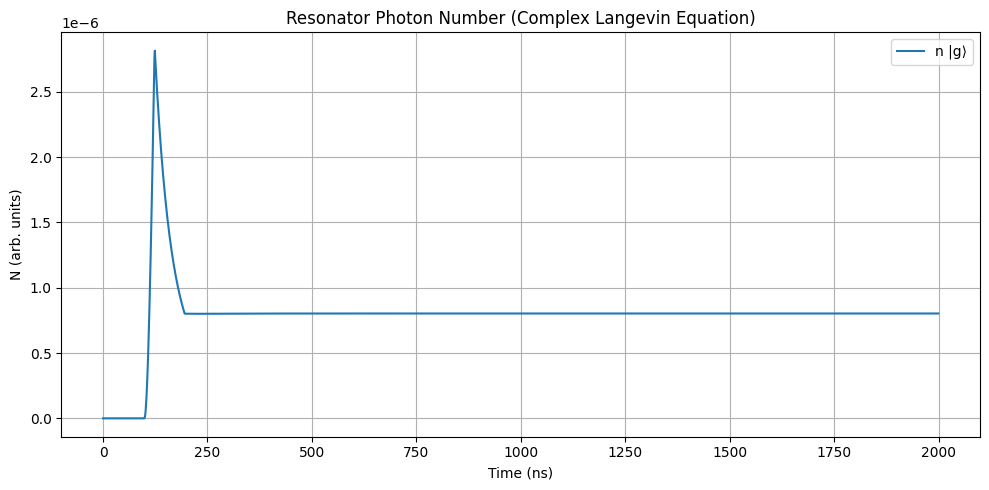

In [145]:
simulate_populate_plot(*params_steady)


In [150]:
optimal_drive = params_steady[4]

# === Your Cost Function ===
def reset_cost(params):
    params = np.append(params, optimal_drive)
    cost = simulate_reset(*params)
    print(f"Params: {params} → Cost: {cost if cost is not None else 'N/A'}")

    return cost

# === Parameter Bounds ===
bounds = [(1e-9, 300e-9),      # Ringup time
          (1e-9, 300e-9),      # Ringdown time
          (1, 15),        # Ringup norm
          (-15, -1),        # Ringdown norm
          ]        # Drive norm

# Extract separate lower and upper bound lists
lower_bounds, upper_bounds = zip(*bounds)

# === Initial Guess and Sigma ===
x0 = [(low + high) / 3 for low, high in bounds]  # Midpoint
# sigma = [1.0, 1.0, 0.5, 0.5, 0.5]  # Step size (can be scalar or list per parameter)
sigmas = [(high - low) * 0.1 for (low, high) in bounds]

# === CMA-ES Optimization ===
es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=0.3,
    inopts={
        'bounds': [list(lower_bounds), list(upper_bounds)],
        'maxiter': 100,
        'CMA_stds': sigmas,
        'verb_disp': 1,
    }
)

# Run the optimization
res = es.optimize(reset_cost)

# Best solution and its cost
# ringup_time, ringdown_time, ringup_norm, ringdown_norm, drive_norm
print("Best reset time:", res.result.fbest)
params_reset = res.result.xbest
params_reset = np.append(params_reset, optimal_drive)

print(f"Reset optimal ringup_time: {params_reset[0]/1e-9} ns, ringdown_time {params_reset[1]/1e-9} ns, ringup_norm {params_reset[2]}, ringdown_norm {params_reset[3]}, drive_norm {params_reset[4]}")


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=414838, Wed Jun 18 17:39:55 2025)
Params: [ 1.11548329e-07  8.69843811e-08  5.31482490e+00 -5.00941809e+00
  2.72675851e+00] → Cost: 423.0
Params: [ 1.05052796e-07  1.00390384e-07  5.12972734e+00 -5.05123904e+00
  2.72675851e+00] → Cost: 424.00000000000006
Params: [ 1.05131985e-07  1.02875005e-07  5.09358793e+00 -5.40256947e+00
  2.72675851e+00] → Cost: 426.0
Params: [ 9.58361017e-08  9.79931047e-08  5.42169264e+00 -5.50567504e+00
  2.72675851e+00] → Cost: 412.0
Params: [ 9.42592926e-08  1.01220244e-07  5.20981757e+00 -5.11380144e+00
  2.72675851e+00] → Cost: 410.00000000000006
Params: [ 1.00573707e-07  9.96133525e-08  4.89674969e+00 -5.68530417e+00
  2.72675851e+00] → Cost: 413.0000000000001
Params: [ 1.13703793e-07  1.06026913e-07  5.71063640e+00 -5.46861341e+00
  2.72675851e+00] → Cost: 447.99999999999994
Params: [ 1.00742915e-07  9.79443534e-08  5.28436752e+00 -6.30298101e+00
  2.72675851e+00] → Cost: 415.0
Iterat #Fevals   fu

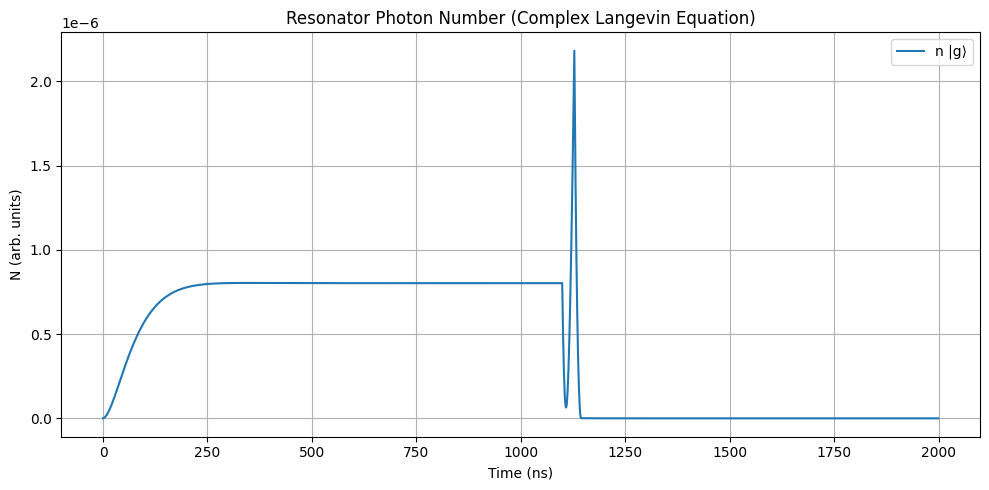

In [151]:
simulate_reset_plot(*params_reset)

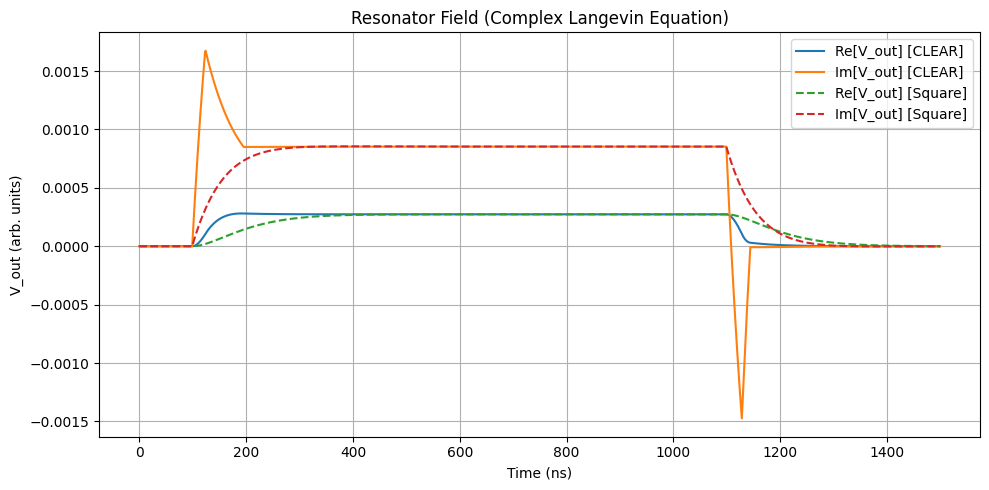

In [177]:
ringup1_amp = params_steady[2]
ringdown1_amp = params_steady[3]
ringup2_amp = params_reset[2]
drive_amp = params_steady[4]
ringdown2_amp = params_reset[3]

optimal_ringup1_time = params_steady[0]
optimal_ringdown1_time = params_steady[1]
optimal_ringup2_time = params_reset[0]
optimal_ringdown2_time = params_reset[1]

# Define drive
def b_in(t):
    try:
        if  t<= pulse_start:
            return 0.0
        elif t<= pulse_start + optimal_ringup1_time:
            return ringup1_amp 
        elif t <= pulse_start + optimal_ringup1_time + optimal_ringdown1_time:
            return ringdown1_amp
        elif t <= pulse_start + pulse_width:
            return drive_amp
        elif t <= pulse_start + pulse_width + optimal_ringdown2_time:
            return ringdown2_amp 
        elif t <= pulse_start + pulse_width + optimal_ringdown2_time + optimal_ringup2_time:
            return ringup2_amp
        else:   
            return 0.0
    
    except Exception as e:
        print(f"b_in error at t={t}: {e}")
        return 0.0
    
def b_in_square(t):
    try:
        if  t<= pulse_start:
            return 0.0
        elif t <= pulse_start + pulse_width:
            return drive_amp
        else:   
            return 0.0
    
    except Exception as e:
        print(f"b_in error at t={t}: {e}")
        return 0.0

# Define Heisenburg picture 
def langevin(t, a_vec, qubit_state):
    omega_eff = chi * qubit_state
    return -1j * omega_eff * a_vec - (k / 2) * a_vec +  1j * np.sqrt(k) * b_in(t)

def langevin_square(t, a_vec, qubit_state):
    omega_eff = chi * qubit_state
    return -1j * omega_eff * a_vec - (k / 2) * a_vec +  1j * np.sqrt(k) * b_in_square(t)

def run_langevin(qubit_state):
    solver = ode(langevin)
    solver.set_integrator('zvode', method='bdf')  # complex-valued ODE solver
    solver.set_initial_value(0.0+0.0j, tlist[0])
    solver.set_f_params(qubit_state)

    a_vals = []

    for _ in range(len(tlist)):
        if not solver.successful():
            print("Integration failed at t =", solver.t)
            break
        solver.integrate(solver.t + dt)
        a_vals.append(solver.y)

    return np.array(a_vals)

def run_langevin_square(qubit_state):
    solver = ode(langevin_square)
    solver.set_integrator('zvode', method='bdf')  # complex-valued ODE solver
    solver.set_initial_value(0.0+0.0j, tlist[0])
    solver.set_f_params(qubit_state)

    a_vals = []

    for _ in range(len(tlist)):
        if not solver.successful():
            print("Integration failed at t =", solver.t)
            break
        solver.integrate(solver.t + dt)
        a_vals.append(solver.y)

    return np.array(a_vals)

# Run for both qubit states
a_0 = run_langevin(1)
a_s = run_langevin_square(1)

plt.figure(figsize=(10, 5))
plt.plot(tlist * 1e9, np.real(a_0), label='Re[V_out] [CLEAR]')
plt.plot(tlist * 1e9, np.imag(a_0), label='Im[V_out] [CLEAR]')
plt.plot(tlist * 1e9, np.real(a_s), '--', label='Re[V_out] [Square]')
plt.plot(tlist * 1e9, np.imag(a_s), '--', label='Im[V_out] [Square]')
plt.xlabel("Time (ns)")
plt.ylabel("V_out (arb. units)")
plt.title("Resonator Field (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


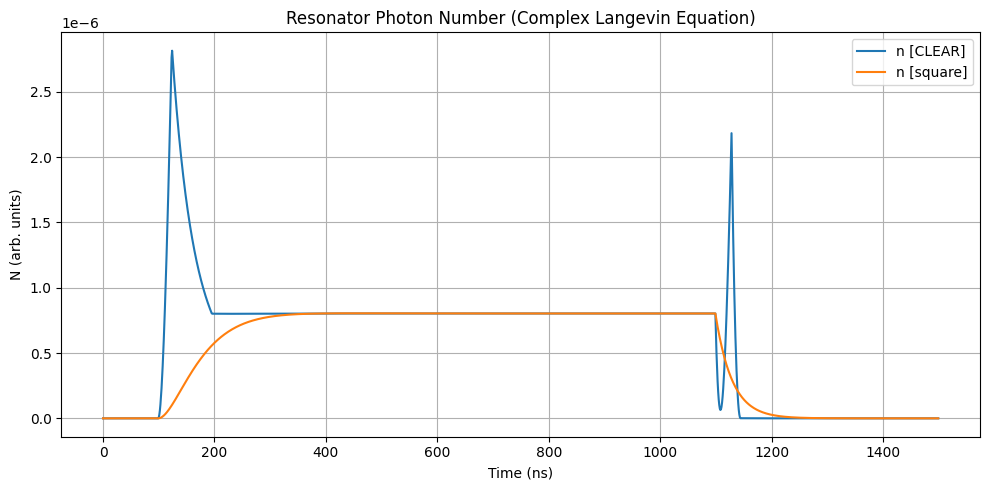

In [178]:
# Use the photon number as metric for optimising CLEAR pulse

photon_0 = np.abs(a_0)**2
photon_s = np.abs(a_s)**2

plt.figure(figsize=(10, 5))
plt.plot(tlist * 1e9, photon_0, label='n [CLEAR]')
plt.plot(tlist * 1e9, photon_s, label='n [square]')
plt.xlabel("Time (ns)")
plt.ylabel("N (arb. units)")
plt.title("Resonator Photon Number (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Interaction with the readout resonator (Lab Frame)

In [ ]:
# Define drive
def envelope(t):
    # Define all transitions using smooth ramps or precomputed segments
    if t <= pulse_start:
        return 0.0
    elif t <= pulse_start + optimal_ringup1_time:
        return ringup1_amp
    elif t <= pulse_start + optimal_ringup1_time + optimal_ringdown1_time:
        return ringdown1_amp
    elif t <= pulse_start + pulse_width:
        return drive_amp
    elif t <= pulse_start + pulse_width + optimal_ringdown2_time:
        return ringdown2_amp
    elif t <= pulse_start + pulse_width + optimal_ringdown2_time + optimal_ringup2_time:
        return ringup2_amp
    else:
        return 0.0
    
def b_in(t):
    env = envelope(t) * np.exp(1j * (w_if * t + phi))
    return np.real(env) * np.cos(w_lo * t) - np.imag(env) * np.sin(w_lo * t)

def langevin(t, a, sigma_z):
    omega_eff = wr + chi * sigma_z
    return -1j * omega_eff * a - (k / 2) * a + 1j * np.sqrt(k) * b_in(t)

def run_langevin(sigma_z):
    solver = ode(langevin)
    solver.set_integrator('zvode', method='bdf')
    solver.set_initial_value(0.0+0.0j, tlist[0])
    solver.set_f_params(sigma_z)

    a_vals = []
    for i in range(len(tlist)):
        if not solver.successful():
            print(f'F {i} {solver.t} {sigma_z}')
            break
        solver.integrate(solver.t + dt)
        a_vals.append(solver.y)

    return np.array(a_vals)

# Simulate for qubit in |0⟩ and |1⟩ (σ_z = +1 and -1)
a_0 = run_langevin(-1)
a_1 = run_langevin(+1)

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/scipy/integrate/_ode.py:438: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


F 125 1.2482315460421211e-07
F 125 1.2489522761841892e-07


### RF response from the resonator: input-output theory

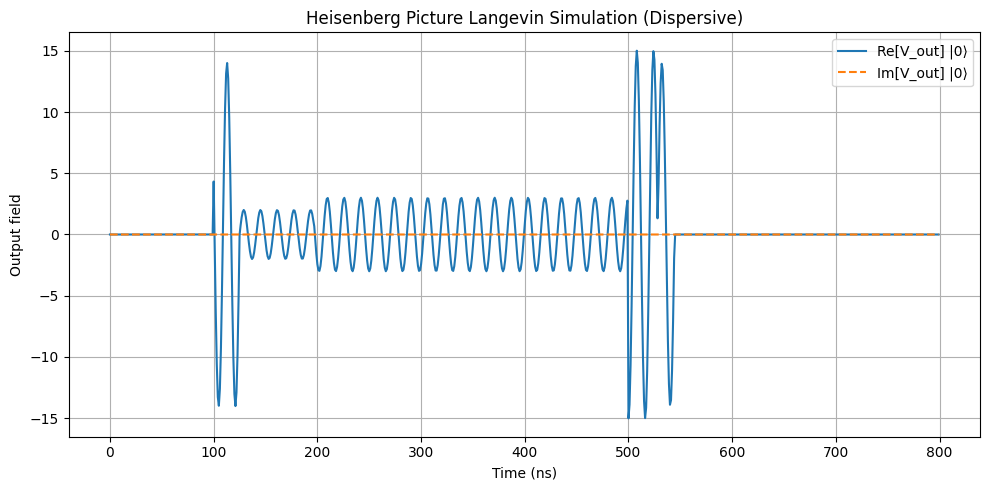

In [ ]:
# Compute output field
V_out_0 = np.sqrt(k) * a_0.flatten() + np.array([b_in(t) for t in tlist.flatten()])
V_out_1 = np.sqrt(k) * a_1.flatten() + np.array([b_in(t) for t in tlist.flatten()])

# Plot
plt.figure(figsize=(10,5))
plt.plot(tlist * 1e9, np.real(V_out_0), label="Re[V_out] |0⟩")
plt.plot(tlist * 1e9, np.real(V_out_1), label="Re[V_out] |1⟩")
plt.plot(tlist * 1e9, np.imag(V_out_0), '--', label="Im[V_out] |0⟩")
plt.plot(tlist * 1e9, np.imag(V_out_1), '--', label="Im[V_out] |1⟩")
plt.xlabel("Time (ns)")
plt.ylabel("Output field")
plt.title("Heisenberg Picture Langevin Simulation (Dispersive)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Demodulation of the RF signal

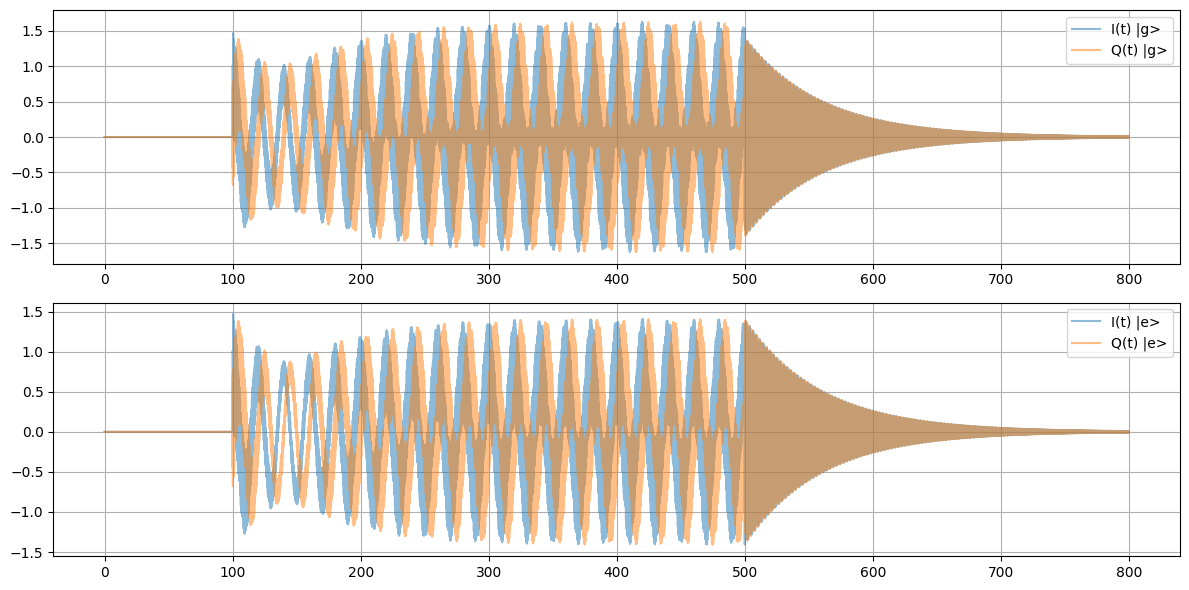

In [ ]:
# Demodulation: complex demodulation
V_down_0 = V_out_0 * np.exp(-1j * w_lo * tlist)
V_down_1 = V_out_1 * np.exp(-1j * w_lo * tlist)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(tlist * 1e9, np.real(V_down_0), label="I(t) |g>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_down_0), label="Q(t) |g>", alpha=0.5)
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(tlist * 1e9, np.real(V_down_1), label="I(t) |e>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_down_1), label="Q(t) |e>", alpha=0.5)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

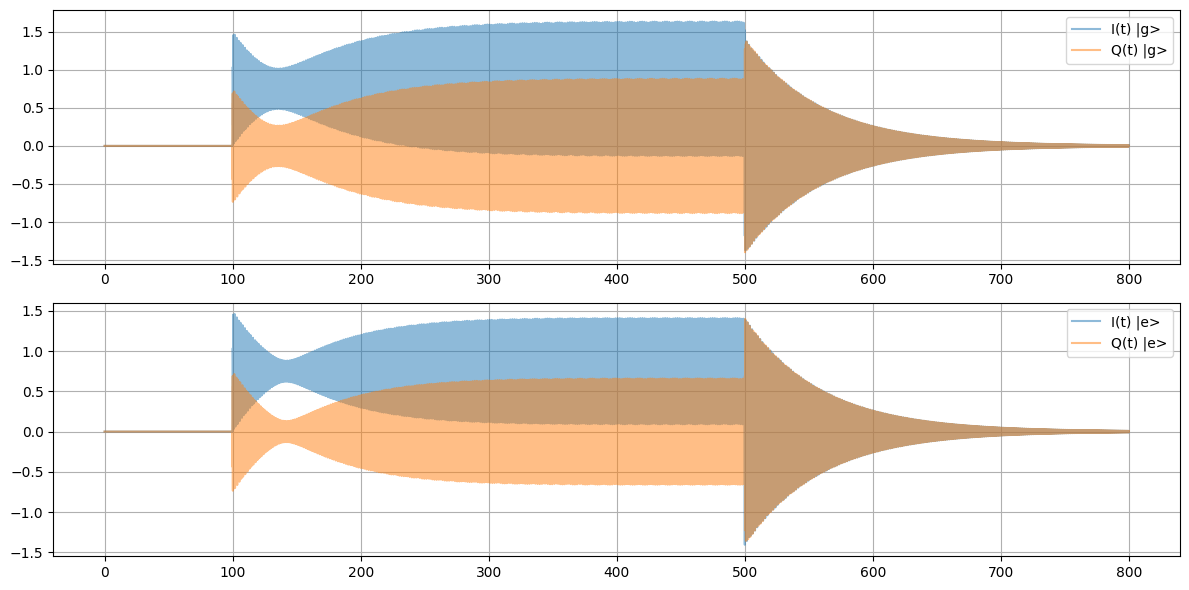

In [481]:
V_baseband_0 = V_down_0 * np.exp(-1j * w_if * tlist)
V_baseband_1 = V_down_1 * np.exp(-1j * w_if * tlist)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(tlist * 1e9, np.real(V_baseband_0), label="I(t) |g>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_baseband_0), label="Q(t) |g>", alpha=0.5)
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(tlist * 1e9, np.real(V_baseband_1), label="I(t) |e>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_baseband_1), label="Q(t) |e>", alpha=0.5)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Integration Weights and Integration

In [486]:
pulse_start = 100e-9
pulse_width = 400e-9
steady_time = 321e-9

integration_start = pulse_start + steady_time
integration_duration = pulse_start + pulse_width
integration_mask = (tlist >= integration_start) & (tlist < integration_start + integration_duration)
integration_time = tlist[integration_mask]

# Optimal integration weights: normalised average trace difference
w = np.conj(V_baseband_1 - V_baseband_0)
w /= np.linalg.norm(w)  # Normalize

S_g = np.sum((V_baseband_0 * w)[integration_mask]) * dt
S_e = np.sum((V_baseband_1 * w)[integration_mask]) * dt

print(f"Demodulated signal |g> S = {S_g:.4f} (magnitude = {np.abs(S_g):.4f}, phase = {np.angle(S_g):.4f} rad)")
print(f"Demodulated signal |e> S = {S_e:.4f} (magnitude = {np.abs(S_e):.4f}, phase = {np.angle(S_e):.4f} rad)")

Demodulated signal |g> S = -0.0000+0.0000j (magnitude = 0.0000, phase = 2.2306 rad)
Demodulated signal |e> S = 0.0000+0.0000j (magnitude = 0.0000, phase = 1.1384 rad)


### Plotting measurement on complex I/Q plane

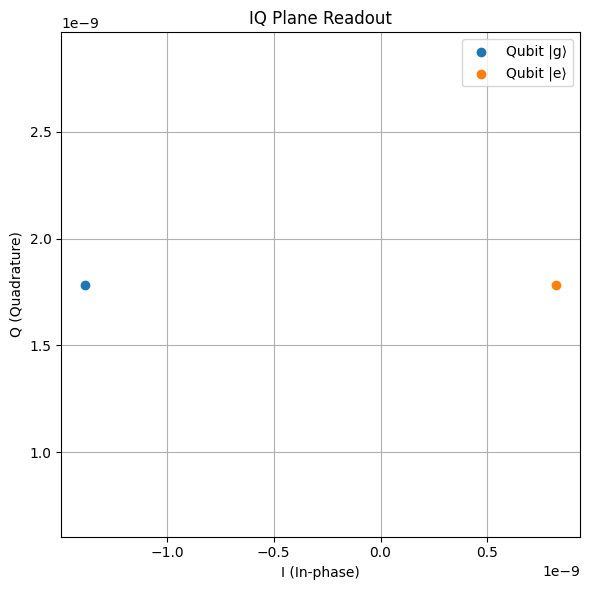

In [487]:
plt.figure(figsize=(6, 6))

plt.scatter(S_g.real, S_g.imag, label='Qubit |g⟩')
plt.scatter(S_e.real, S_e.imag, label='Qubit |e⟩')

plt.xlabel("I (In-phase)")
plt.ylabel("Q (Quadrature)")
plt.title("IQ Plane Readout")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()